/tmp/ipykernel_12129/513050674.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_norm_r1 = df_norm[df["run"] == "R1"]
/tmp/ipykernel_12129/513050674.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_norm_r2 = df_norm[df["run"] == "R2"]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3456 entries, 0 to 3455
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Geneid  3456 non-null   object 
 1   sample  3456 non-null   object 
 2   count   3456 non-null   int64  
 3   time    3456 non-null   float64
 4   run     3456 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 135.1+ KB


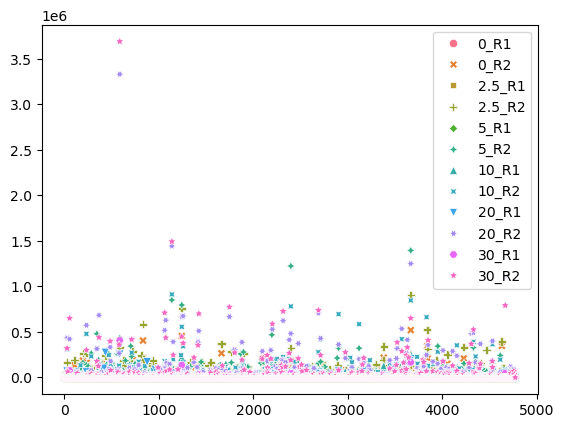

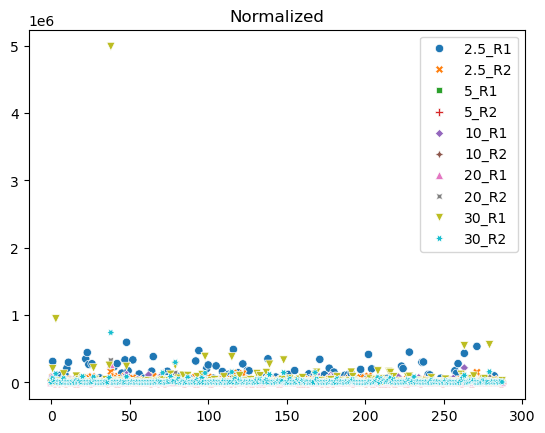

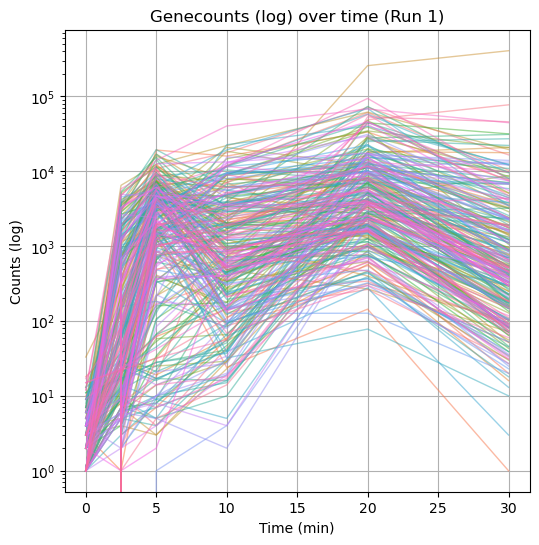

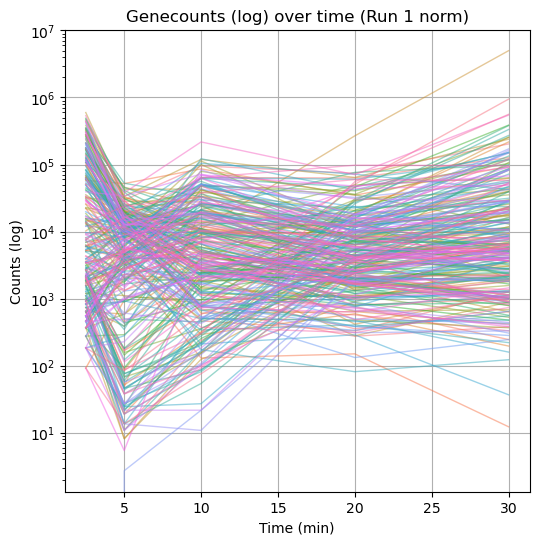

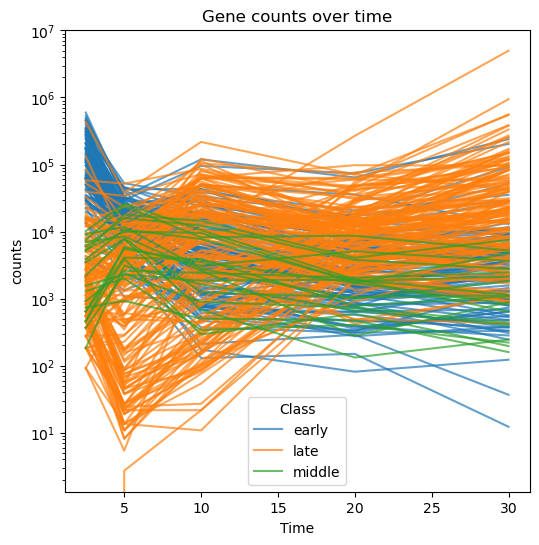

In [ ]:
# Exploratory Data Analysis Notebook

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function that formats a dataframe for plotting
def processDataframe(df):
    # Drop unneeded cols
    df = df.drop(columns=["Entity", "Symbol"], errors="ignore")
    
    # Format dataframe
    df_long = df.melt(id_vars=["Geneid"], var_name="sample", value_name="count")

    # Extract timepoint and run number from sample name ("2.5_R1" → "2.5")
    df_long[["time", "run"]] = df_long["sample"].str.extract(r"^([\d.]+)_?(R\d+)")
    df_long["time"] = df_long["time"].astype(float)
    return df_long


###
### Visualize raw vs cleaned datasets: Distribution & Gene counts over time
### (Using normalized dataset for now)
###

# Load the dataset
data = pd.read_csv('../data/guegler_2021/Guegler_T4_minusToxIN_full_raw_counts.tsv', sep="\t")
# Split into host and phage
data_phage = data[data["Entity"] == "phage"]
data_host  = data[data["Entity"] == "host"]
df = processDataframe(data_phage)

# Load normalized dataset (phage only) (TODO: change for cleaned dataset when available)
data_norm = pd.read_csv('normalized_counts_guegler_phage_T4.csv', sep=",")
df_norm = processDataframe(data_norm)


# Split runs (TODO: Change this when using averaged run values)
df_r1 = df[df["run"] == "R1"]
df_r2 = df[df["run"] == "R2"]

df_norm_r1 = df_norm[df["run"] == "R1"]
df_norm_r2 = df_norm[df["run"] == "R2"]


# Display basic information about the dataset
df.info()

# Visualize data distributions
sns.scatterplot(data)
plt.show()
plt.title("Normalized")
sns.scatterplot(data_norm)
plt.show()


titles = ["Run 1", "Run 1 norm"]
# Plot one line per gene
for (df, title) in zip([df_r1, df_norm_r1], titles):
    plt.figure(figsize=(6, 6))
    sns.lineplot(data=df, x="time", y="count", hue="Geneid", legend=False, linewidth=1, alpha=0.5, estimator=None)
    plt.yscale("log")
    plt.title(f"Genecounts (log) over time ({title})")
    plt.xlabel("Time (min)")
    plt.ylabel("Counts (log)")
    plt.grid(True)
plt.show()


###
### Visualization for gene classes
###

# Use normalized data and remove run 2 for easier handling
data_norm = data_norm.drop(columns=["Entity", "Symbol"], errors="ignore")
data_norm = data_norm.drop(columns=[col for col in data_norm.columns if col.endswith("R2")])
# print(data_norm)

# Arbetraty classification of gene (highest value at times 2.5, 5, rest = early, middle, late)
early  = ["2.5_R1", "2.5_R2"]
middle = ["5_R1", "5_R2"]
late   = ["10_R1", "10_R2", "20_R1", "20_R2", "30_R1", "30_R2"]

def classify(column):
    if column in early:
        return "early"
    elif column in middle:
        return "middle"
    elif column in late:
        return "late"

# Get highest value column
max_columns = data_norm.drop(columns="Geneid").idxmax(axis=1)

# Classify genes
data_norm["class"] = max_columns.apply(classify)

#print(data_norm)

# Format to long format
long_df = data_norm.melt(id_vars=["Geneid", "class"], 
                  value_vars=["2.5_R1", "5_R1", "10_R1", "20_R1", "30_R1"],
                  var_name="timepoints", value_name="counts")
long_df["time"] = long_df["timepoints"].str.extract(r"([\d.]+)").astype(float)  # Get times from name (20_R1 -> 20)

# print(df_long)

# Draw plot
plt.figure(figsize=(6, 6))
sns.lineplot(data=long_df, x="time", y="counts", hue="class", 
             units="Geneid", estimator=None, alpha=0.7)

plt.title("Gene counts over time")
plt.xlabel("Time")
plt.ylabel("counts")
plt.yscale("log")
plt.legend(title="Class")
plt.show()